In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from google.colab import drive
from zipfile import ZipFile



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create directory to store the dataset if it doesn't exist
!mkdir -p /content/dataset

# Download the Cats vs Dogs dataset from Microsoft's server
!wget -P /content/ https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

# Extract the downloaded zip file into the dataset directory
with ZipFile('/content/kagglecatsanddogs_5340.zip', 'r') as dataset_zip:
    dataset_zip.extractall('/content/dataset')

--2025-06-19 12:27:27--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.218.186.12, 2600:1409:3c00:c80::317f, 2600:1409:3c00:c8c::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.218.186.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/content/kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  70.3MB/s    in 13s     

2025-06-19 12:27:40 (61.7 MB/s) - ‘/content/kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:

!find /content/dataset/PetImages -type f -name "*.jpg" -size -10k -delete

In [ ]:
# Image preprocessing and HOG feature extraction settings
TARGET_RESOLUTION = 128  # Images will be resized to this width/height
GRADIENT_BINS = 9  # Number of orientation bins for HOG
CELL_DIMENSIONS = (8, 8)  # Size of each cell for HOG computation
BLOCK_DIMENSIONS = (2, 2)  # Block size for normalization
MAX_IMAGES_PER_CATEGORY = 2000  # Prevents memory overload

def generate_feature_dataset():
    """
    Processes cat/dog images, computes HOG features, and returns structured data.

    Returns:
        List of (HOG_feature_vector, class_label) pairs
    """
    extracted_features = []

    for animal_type in ['Cat', 'Dog']:  # Folders are case-sensitive
        dataset_path = os.path.join('/content/dataset/PetImages', animal_type)
        label = 0 if animal_type == 'Cat' else 1  # 0 for Cat, 1 for Dog
        images_processed = 0

        for filename in os.listdir(dataset_path):
            if images_processed >= MAX_IMAGES_PER_CATEGORY:
                break

            try:
                full_image_path = os.path.join(dataset_path, filename)
                mono_image = cv2.imread(full_image_path, cv2.IMREAD_GRAYSCALE)

                # Skip if image is corrupt or unreadable
                if mono_image is None:
                    continue

                # Standardize image size and extract HOG features
                resized_img = cv2.resize(mono_image, (TARGET_RESOLUTION, TARGET_RESOLUTION))
                feature_vector = hog(
                    resized_img,
                    orientations=GRADIENT_BINS,
                    pixels_per_cell=CELL_DIMENSIONS,
                    cells_per_block=BLOCK_DIMENSIONS,
                    visualize=False,
                    feature_vector=True
                )

                extracted_features.append([feature_vector, label])
                images_processed += 1

            except Exception as img_error:
                # Skip images causing errors (e.g., unsupported format)
                continue

    return extracted_features

In [ ]:
def separate_features_and_labels(feature_label_pairs):
    """
    Splits the dataset into feature vectors and their corresponding labels.

    Args:
        feature_label_pairs: List of tuples where each tuple contains
                           (feature_vector, class_label)

    Returns:
        feature_vectors: 2D numpy array of all HOG feature vectors
        labels: 1D numpy array of corresponding class labels
    """
    feature_vectors = np.array([features for features, _ in feature_label_pairs])
    labels = np.array([label for _, label in feature_label_pairs])

    return feature_vectors, labels


Loading and processing dataset...
Successfully loaded 4000 samples (balanced classes).
Preprocessing features...
Feature dimensionality after PCA: (4000, 1591)
Training machine learning model...
Training SVM classifier...
Model Accuracy: 0.72
Detailed Performance Report:
              precision    recall  f1-score   support

         Cat       0.73      0.74      0.74       422
         Dog       0.71      0.69      0.70       378

    accuracy                           0.72       800
   macro avg       0.72      0.72      0.72       800
weighted avg       0.72      0.72      0.72       800

Visualizing HOG features...


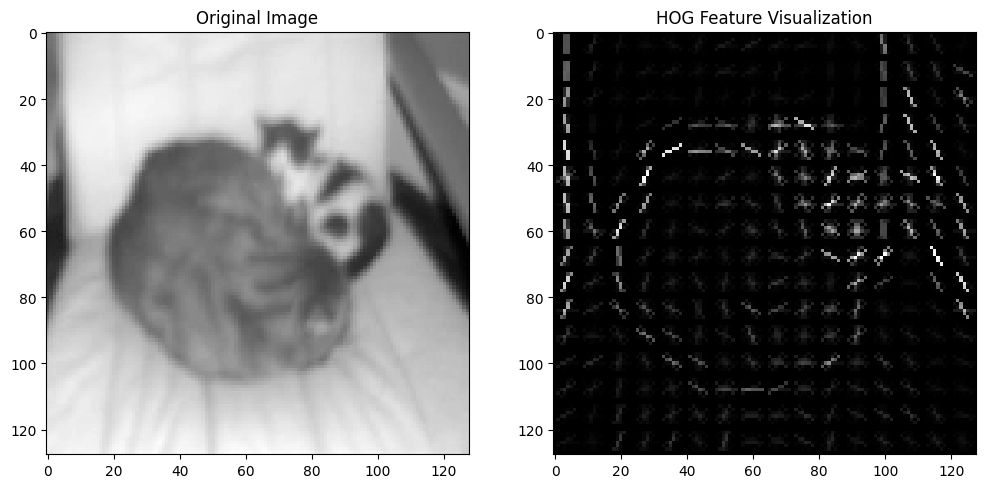

In [ ]:
def preprocess_features_and_labels(feature_label_data):
    # Unpack features and labels
    feature_vectors = np.array([features for features, _ in feature_label_data])
    labels = np.array([label for _, label in feature_label_data])

    # Standardize features
    feature_scaler = StandardScaler()
    standardized_features = feature_scaler.fit_transform(feature_vectors)

    # Reduce dimensionality while preserving 95% variance
    pca_model = PCA(n_components=0.95)
    reduced_features = pca_model.fit_transform(standardized_features)

    return reduced_features, labels, pca_model, feature_scaler


def train_support_vector_machine(features, labels):
    """
    Trains and evaluates an SVM classifier with RBF kernel.

    Args:
        features: Input feature vectors
        labels: Corresponding class labels

    Returns:
        trained_svm: Fitted SVM model
    """
    # Split into training and test sets
    features_train, features_test, labels_train, labels_test = train_test_split(
        features, labels, test_size=0.2, random_state=42
    )

    # Initialize SVM with RBF kernel
    svm_classifier = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42
    )

    # Train the model
    print("Training SVM classifier...")
    svm_classifier.fit(features_train, labels_train)

    # Evaluate performance
    predictions = svm_classifier.predict(features_test)
    model_accuracy = accuracy_score(labels_test, predictions)
    performance_report = classification_report(
        labels_test,
        predictions,
        target_names=['Cat', 'Dog']
    )

    print(f"Model Accuracy: {model_accuracy:.2f}")
    print("Detailed Performance Report:")
    print(performance_report)

    return svm_classifier


def visualize_hog_features():
    """
    Displays a sample image and its corresponding HOG features visualization.
    """
    # Load sample cat image
    sample_cat_images = os.listdir(os.path.join('/content/dataset/PetImages/Cat'))
    sample_image_path = os.path.join('/content/dataset/PetImages/Cat', sample_cat_images[0])
    grayscale_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
    # Use the global TARGET_RESOLUTION instead of undefined IMAGE_SIZE
    resized_image = cv2.resize(grayscale_image, (TARGET_RESOLUTION, TARGET_RESOLUTION))

    # Compute HOG features and visualization
    hog_features, hog_visualization = hog(
        resized_image,
        # Use global variables for HOG parameters
        orientations=GRADIENT_BINS,
        pixels_per_cell=CELL_DIMENSIONS,
        cells_per_block=BLOCK_DIMENSIONS,
        visualize=True,
        feature_vector=True
    )

    # Create comparison plot
    figure, (original_axis, hog_axis) = plt.subplots(1, 2, figsize=(12, 6))
    original_axis.imshow(resized_image, cmap='gray')
    original_axis.set_title('Original Image')
    hog_axis.imshow(hog_visualization, cmap='gray')
    hog_axis.set_title('HOG Feature Visualization')
    plt.show()


# Main execution pipeline
if __name__ == "__main__":
    print("Loading and processing dataset...")
    # Corrected the function call from load_data to generate_feature_dataset
    dataset = generate_feature_dataset()
    print(f"Successfully loaded {len(dataset)} samples (balanced classes).")

    print("Preprocessing features...")
    processed_features, target_labels, pca_transformer, feature_normalizer = \
        preprocess_features_and_labels(dataset)
    print(f"Feature dimensionality after PCA: {processed_features.shape}")

    print("Training machine learning model...")
    trained_model = train_support_vector_machine(processed_features, target_labels)

    print("Visualizing HOG features...")
    visualize_hog_features()